In [1]:
import emcee
import numpy as np 
import corner as DFM
# --- emanu---
from emanu import compressor as Comp
from emanu import forecast as Forecast

In [2]:
# --- plotting --- 
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['axes.xmargin'] = 1
mpl.rcParams['xtick.labelsize'] = 'x-large'
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['ytick.labelsize'] = 'x-large'
mpl.rcParams['ytick.major.size'] = 5
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['legend.frameon'] = False
%matplotlib inline

In [3]:
theta_true = np.array([0.5, 0.5])
cov_true = np.identity(20)
def model(theta): 
    return theta[0] * np.arange(20) + theta[1]
X_true = model(theta_true)

In [10]:
# initialize walkers randomly drawn from prior 
ndim = len(theta_true)

prior_range = np.array([[0.25, 0.75], [-0.5, 1.5]])


In [12]:
X_data = np.random.multivariate_normal(model(theta_true), cov_true, size=10000)
cov_data = np.cov(X_data.T)

cinv_data = np.linalg.inv(cov_data)

nmock, ndata = X_data.shape
#cinv_data *= float(nmock - ndata - 2)/float(nmock - 1) 

(0.0, 19.0)

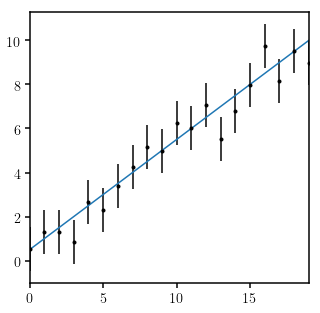

In [5]:
fig = plt.figure(figsize=(5,5))
sub = fig.add_subplot(111)
sub.errorbar(range(len(X_true)), X_data[0], np.sqrt(np.diag(cov_true)), fmt='.k')
sub.plot(model(theta_true))
sub.set_xlim(0., 19.)

In [13]:
theta_0m = np.array([theta_true[0]-0.1, theta_true[1]])
theta_0p = np.array([theta_true[0]+0.1, theta_true[1]])
theta_1m = np.array([theta_true[0], theta_true[1]-0.1])
theta_1p = np.array([theta_true[0], theta_true[1]+0.1])
dXd0 = (model(theta_0p) - model(theta_0m))/0.2
dXd1 = (model(theta_1p) - model(theta_1m))/0.2
dXdtheta = np.array([dXd0, dXd1])

In [14]:
Fij = Forecast.Fij(dXdtheta, cinv_data) # fisher 
Finv = np.linalg.inv(Fij)

In [15]:
# Fisher "true" 1-sigma values
print np.sqrt(np.diag(Finv))

[0.03848768 0.42583348]


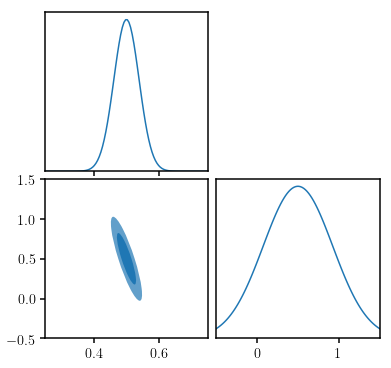

In [16]:
fig = Forecast.plotFisher([Finv], theta_true, ranges=prior_range)

In [17]:
def Fij_nmock(nmock): 
    _cov = np.cov(X_data[:nmock].T)
    _cinv = np.linalg.inv(_cov)
    return Forecast.Fij(dXdtheta, _cinv) # fisher 

In [34]:
def Fij_nmock_hartlap(nmock): 
    _cov = np.cov(X_data[:nmock].T)
    _cinv = np.linalg.inv(_cov)
    fhartlap = float(nmock - ndata - 2)/float(nmock - 1) 
    return Forecast.Fij(dXdtheta, _cinv * fhartlap)

In [26]:
def Fij_nmock_tfactor(nmock): 
    _cov = np.cov(X_data[:nmock].T)
    _cinv = np.linalg.inv(_cov)
    ftdist = float(nmock**2)/float((nmock+ndata+1)*(nmock+ndata-1))
    return Forecast.Fij(dXdtheta, _cinv) * ftdist

In [41]:
Nmocks = np.linspace(50, 2000, 100).astype(int) #[50, 100, 200, 300, 400, 500, 600, 1000, 2000]#, 3000, 4000, 5000, 10000]
Fijs, Fijs_hart, Fijs_tdist = [], [], [] 
for nm in Nmocks: 
    Fijs.append(Fij_nmock(nm))
    Fijs_hart.append(Fij_nmock_hartlap(nm))
    Fijs_tdist.append(Fij_nmock_tfactor(nm))
Fijs = np.array(Fijs)
Fijs_hart = np.array(Fijs_hart)
Fijs_tdist = np.array(Fijs_tdist)

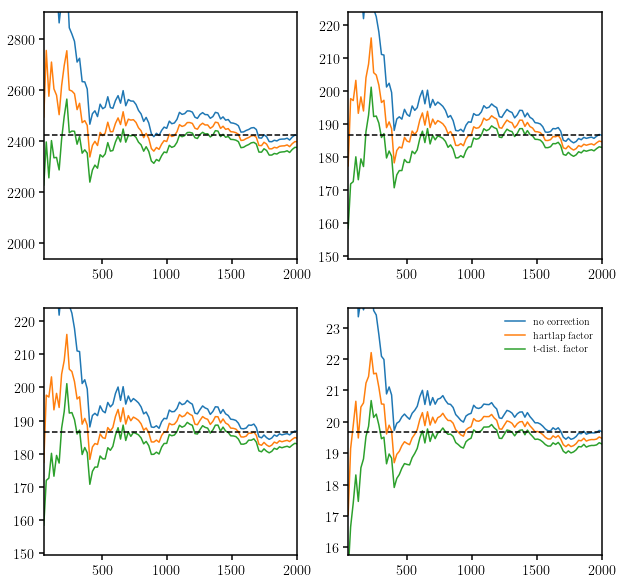

In [42]:
fig = plt.figure(figsize=(10,10))
for i,j in zip([0, 0, 1, 1], [0, 1, 0, 1]): 
    sub = fig.add_subplot(2,2,2*i+j+1)
    sub.plot(Nmocks, Fijs[:,i,j], label='no correction')
    sub.plot(Nmocks, Fijs_hart[:,i,j], label='hartlap factor')
    sub.plot(Nmocks, Fijs_tdist[:,i,j], label='t-dist. factor')
    sub.plot(Nmocks, np.repeat(Fijs[-1,i,j], len(Nmocks)), c='k', ls='--')
    sub.set_xlim(Nmocks[0], Nmocks[-1])
    sub.set_ylim(0.8*Fijs[-1,i,j], 1.2*Fijs[-1,i,j])
sub.legend(loc='upper right')

In [21]:
print Fijs[:,0,0]

[4365.01155084 3419.92907673 3033.89299353 2535.08131724 2453.13103402
 2452.78009553 2445.79450381]
